In [1]:
"""
Pairwise registration evaluation with meanshift filter denoising for both affine and deformable registration.
"""
import sys
sys.path.append('../spami/')
import time

import json
import os
from os.path import join, exists
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from greedyfhist.registration import GreedyFHist
from greedyfhist.options import RegistrationOptions, RegistrationOptions2
from greedyfhist.utils.metrics import compute_tre

from miit.reg_graph import RegGraph
from miit.utils.utils import create_if_not_exists, clean_configs

In [2]:
core_name = '045_01'
config_path = os.path.join('../spami/configs/cores_hr/', core_name + '.json')
graph = RegGraph.from_config_path(config_path)
# with open(config_path, 'r') as f:
#     config = json.load(f)
#     config = clean_configs(config)
#     # config = filter_node_ids(config, section_ids)
# graph = RegGraph.from_config(config)        

Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".


In [3]:
moving_section = graph.sections[9]
fixed_section = graph.sections[8]

In [4]:
moving_image = moving_section.image.data.copy()
fixed_image = fixed_section.image.data.copy()
moving_mask = moving_section.segmentation_mask.data.copy()
fixed_mask = fixed_section.segmentation_mask.data.copy()


In [5]:
options = RegistrationOptions2()
options.affine_registration_options.preprocessing_options.enable_denoising = True
options.affine_registration_options.resolution = (1024, 1024)
options.affine_registration_options.n_threads = 8
options.affine_registration_options.keep_affine_transform_unbounded = True
options.affine_registration_options.rigid_iterations = 10000
options.nonrigid_registration_options.resolution = (1024, 1024)
options.nonrigid_registration_options.preprocessing_options.enable_denoising = False
options.nonrigid_registration_options.n_threads = 8
options.remove_temporary_directory = True

In [6]:
options.affine_registration_options

AffineGreedyOptions(dim=2, resolution=(1024, 1024), preprocessing_options=PreprocessingOptions(moving_sr=30, moving_sp=25, fixed_sr=30, fixed_sp=25, temporary_directory='tmp', remove_temporary_directory=True, yolo_segmentation_min_size=5000, enable_denoising=True), kernel_size=10, cost_function='ncc', rigid_iterations=10000, ia='ia-com-init', iteration_pyramid=[100, 50, 10], n_threads=8, keep_affine_transform_unbounded=True)

In [7]:
registerer = GreedyFHist(path_to_greedy='/mnt/work/workbench/maximilw/applications/test/greedy/build2/greedy')

In [8]:
reg_result = registerer.register2_(moving_img=moving_image,
                                   fixed_img=fixed_image,
                                   moving_img_mask=moving_mask,
                                   fixed_img_mask=fixed_mask,
                                   options=options)

warped_image = registerer.transform_image(moving_image, reg_result.forward_transform, 'LINEAR')

In [9]:
reg_result.reg_params

{'moving_resampling_factor': 1,
 'fixed_resampling_factor': 1,
 'original_moving_image_size': (2985, 2920),
 'original_fixed_image_size': (2889, 2868),
 'cropping_params_mov': (0, 2984, 0, 2919),
 'cropping_params_fix': (0, 2888, 0, 2867),
 'original_shape_fixed_image': (2889, 2868, 3),
 'moving_padding': (32, 33, 0, 0),
 'fixed_padding': (58, 59, 48, 48),
 'cropped_padded_mov_mask': (0, 2983, 32, 2950),
 'cropped_padded_fix_mask': (48, 2935, 58, 2924),
 'com_x': 7.2043557814488395,
 'com_y': 27.52420221868556,
 'offset': 106,
 'affine_iteration_vec': [100, 50, 10],
 'deformable_iteration_vec': [100, 100, 50, 10]}

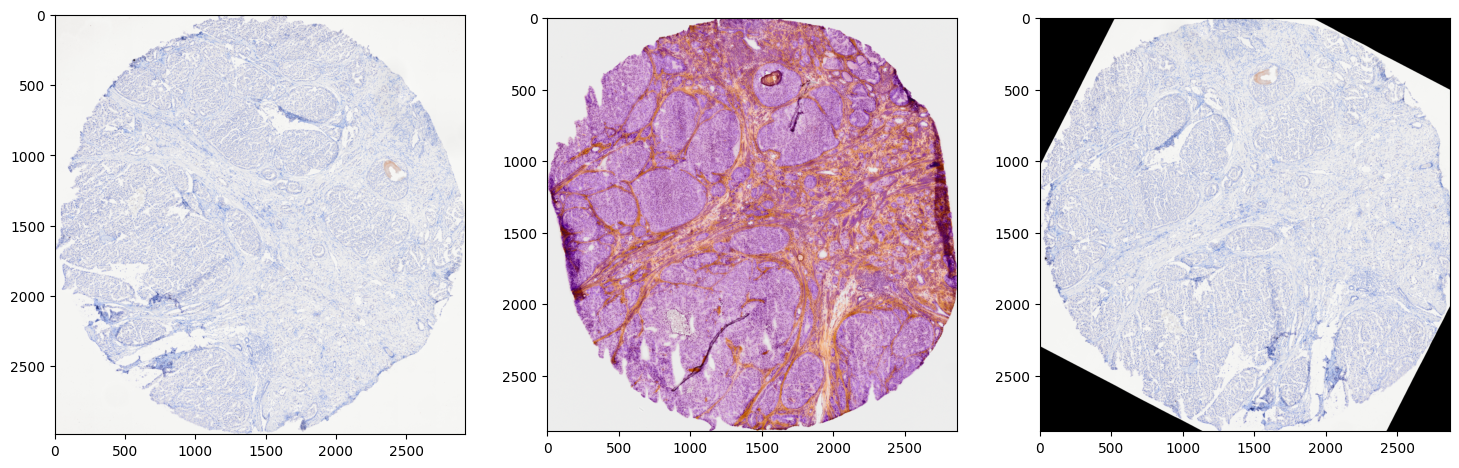

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(moving_image)
axs[1].imshow(fixed_image)
axs[2].imshow(warped_image)